# MAIN
This is the master notebook for my AirBnB Recruiting Challenge work. Changes and additions are made by branching and merging.

Other possible branches:
* Explore
* Prepocessing
* Features
* Models
* Multiclass
* Imbalance
* Validation
* Ensembels


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("talk")

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Preprocessing

In [77]:
def preprocess_missing(df):
    ##AGE
    #Remove all ages outside of range, set to -1 for separate categorisation //impute for logistic regression
    df.loc[df.age > 95, 'age'] = -1
    df.loc[df.age < 13, 'age'] = -1
    df.fillna(-1,inplace=True)

    ## GENDER
    # Set missing values to own category
    df['gender'].replace('-unknown-',np.nan, inplace=True)
    #df['gender'].fillna('MISSING',inplace=True)

    ## FIRST AFFILIATE TRACKED
    # Set missing to untracked, hopefully the same
    df['first_affiliate_tracked'].fillna('untracked',inplace=True)
    
    ## Get rid of date_first_booking
    df.drop(['id','date_first_booking'],axis=1,inplace=True)
    
    return df

def preprocess_features(df):
    ## dates
    
    # date_account_created
    dac = np.vstack(df.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
    df['dac_year'] = dac[:,0]
    df['dac_month'] = dac[:,1]
    df['dac_day'] = dac[:,2]
    df.drop(['date_account_created'],axis=1,inplace=True)
    
    #time first active
    tfa = np.vstack(df.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
    df['tfa_year'] = tfa[:,0]
    df['tfa_month'] = tfa[:,1]
    df['tfa_day'] = tfa[:,2]
    df['tfa_hour'] = tfa[:,3]
    df.drop(['timestamp_first_active'],axis=1,inplace=True)
    
    
    ## One-Hot Encoding
    categorical_features = ['affiliate_channel','affiliate_provider','first_affiliate_tracked',
                            'first_browser','first_device_type','gender','language','signup_app','signup_flow','signup_method'
                           ]
    
    df = pd.get_dummies(df,columns=categorical_features)
    
    return df

def preprocess_all(df):

    df_p = preprocess_missing(df)
    df_p = preprocess_features(df_p)
    
    return(df_p)

In [68]:
# Load data into DataFrames
train_users = pd.read_csv('input/train_users_2.csv')
test_users = pd.read_csv('input/test_users.csv')

In [78]:
#temp = train_users.drop('country_destination',axis=1)
X = preprocess_all(train_users.drop(['country_destination'],axis=1))
y = train_users['country_destination']

# SET UP CLASSIFIER

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

In [72]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_int = le.fit_transform(y)
y_int

array([ 7,  7, 10, ...,  7,  7,  7], dtype=int64)

Feature ranking:
1. feature 7 (0.188990)
2. feature 0 (0.170843)
3. feature 3 (0.135698)
4. feature 6 (0.135633)
5. feature 5 (0.072775)
6. feature 2 (0.072730)
7. feature 1 (0.019367)
8. feature 4 (0.019055)
9. feature 105 (0.018184)
10. feature 153 (0.010201)
11. feature 154 (0.009454)
12. feature 103 (0.009370)
13. feature 104 (0.008054)
14. feature 41 (0.007220)
15. feature 35 (0.006551)
16. feature 50 (0.006217)
17. feature 59 (0.005639)
18. feature 97 (0.004900)
19. feature 38 (0.004821)
20. feature 139 (0.004334)
21. feature 100 (0.004315)
22. feature 83 (0.004000)
23. feature 136 (0.003713)
24. feature 112 (0.003424)
25. feature 13 (0.003421)
26. feature 24 (0.003226)
27. feature 14 (0.003201)
28. feature 63 (0.002949)
29. feature 9 (0.002909)
30. feature 42 (0.002895)
31. feature 40 (0.002641)
32. feature 134 (0.002503)
33. feature 15 (0.002458)
34. feature 138 (0.002169)
35. feature 20 (0.002123)
36. feature 102 (0.002097)
37. feature 10 (0.002080)
38. feature 71 (0.001948)
3

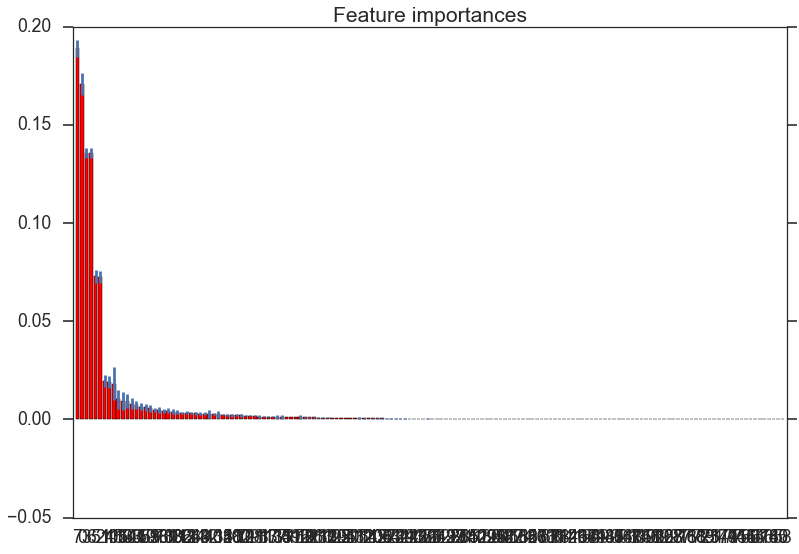

In [79]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=100,
                              random_state=0)



forest.fit(X, y_int)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [84]:
X.columns[[7,0,3,6,5,2,1,4,105]]

Index(['tfa_hour', 'age', 'dac_day', 'tfa_day', 'tfa_month', 'dac_month',
       'dac_year', 'tfa_year', 'gender_MISSING'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_int = le.fit_transform()
y_int

In [85]:
##Let's make this binary classification.
booked = y!='NDF'

In [87]:
#train_users = train_users[pd.to_datetime(train_users)]
X = preprocess_all(train_users.drop(['country_destination'],axis=1))
y = train_users['country_destination']

88908

In [101]:
## Let's get a classifier going
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, booked, random_state=0)

clf = RandomForestClassifier(n_estimators=25)
clf.fit(Xtrain,ytrain)
ypred = clf.predict(Xtest)


In [96]:
print('Accuracy = ',metrics.accuracy_score(ytest,ypred))
print('Recall = ',metrics.recall_score(ytest,ypred))
print('Precision = ',metrics.precision_score(ytest,ypred))

Accuracy =  0.65635365328
Recall =  0.564334903951
Precision =  0.588157521957


In [97]:
FeatureImportances = pd.Series(index=X.columns,data=clf.feature_importances_).sort_values(ascending=False)

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


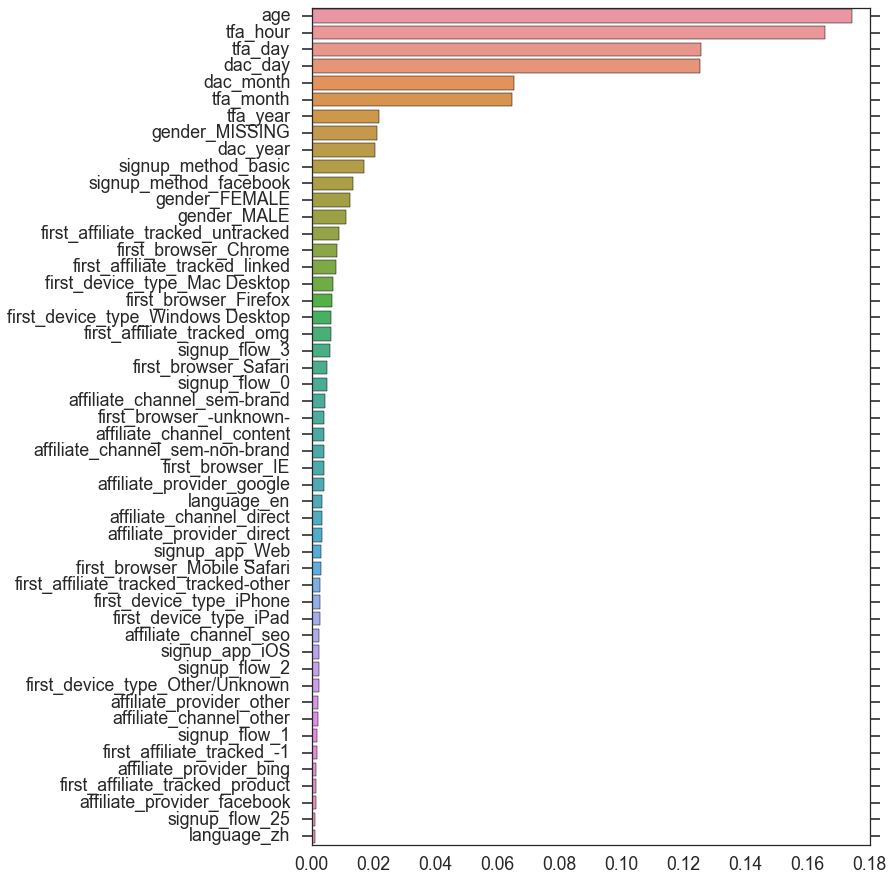

In [98]:
k = 50
plt.figure(figsize=(10,15))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances.head(k))
#plt.xticks(rotation = 90)